<font color="#CA0032"><h1 align="left">**Redes recurrentes profundas**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Predicción de series temporales**</h1></font>

<h2 align="left">---</h2>

<font color="#6E6E6E"><h2 align="left">--</h2></font>

**Notebook: **

**Modificaciones: Francisco**

### **Usaremos un esquema many to one:**

<img src="https://drive.google.com/uc?export=download&id=1iokh576AiK2iFhftPogSBsNXixAi-LBg" align="center" style="float" width="500">

In [1]:
COLAB = True

## <font color="#CA3532"> **1. Importar librerías**

In [8]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GRU
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import os

# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

In [4]:
def download_file_from_google_drive(file_id, dest_file, unzip=False):
  aux = "'https://drive.usercontent.google.com/download?id={}&export=download&confirm=t&uuid=9699f0e2-e760-49fc-b12e-49f140095280'".format(file_id)
  !wget $aux -O $dest_file
  if unzip:
    !unzip -qq -o $dest_file
    !rm $dest_file

## <font color="#CA3532"> **2. Carga de datos**

In [ ]:
!ls "/content/drive/MyDrive/PC4/data/"

ls: cannot access '/content/drive/MyDrive/PC4/data/': No such file or directory


In [ ]:
!ls

drive  sample_data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# === Cargar dataset procesado desde tu carpeta Fracis===
# Ruta al fichero en tu drive/proyecto
data = pd.read_csv('/content/drive/MyDrive/Master_Inteligencia_Artificial_MBIT/Proyectos Consolidación/PC4 Series Temporales/datos_diarios_tienda2.csv')


# Vista rápida
data.head(20)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,85,2,2013-01-01,4220.0,619.0,1,0,1,0,1,0,0
1,85,3,2013-01-02,6069.0,914.0,1,0,1,1,0,0,0
2,85,4,2013-01-03,5246.0,820.0,1,0,1,1,0,0,0
3,85,5,2013-01-04,5339.0,805.0,1,0,1,1,0,0,0
4,85,6,2013-01-05,5774.0,772.0,1,0,0,1,0,0,0
5,85,7,2013-01-06,10509.0,1509.0,1,0,0,1,0,0,0
6,85,1,2013-01-07,8990.0,1119.0,1,1,0,1,0,0,0
7,85,2,2013-01-08,7300.0,914.0,1,1,0,1,0,0,0
8,85,3,2013-01-09,6523.0,891.0,1,1,0,1,0,0,0
9,85,4,2013-01-10,7434.0,946.0,1,1,0,1,0,0,0


In [ ]:
#cargamos datos con el fichero datos_diarios_tienda1 (con mes)

# if COLAB:
#     download_file_from_google_drive(file_id='1ZzLsZ7od8UryXi0x_xpbxwCLuiA2bRNH', dest_file='./datos_diarios_tienda2.csv')

# data = pd.read_csv('datos_diarios_tienda2.csv')
# data.head(20)
# https://drive.google.com/file/d/1ZzLsZ7od8UryXi0x_xpbxwCLuiA2bRNH/view?usp=sharing

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,881.0,85.000000,0.000000,85.0,85.0,85.0,85.0,85.0
DayOfWeek,881.0,4.003405,1.999713,1.0,2.0,4.0,6.0,7.0
Sales,881.0,7260.399546,2275.912174,3215.0,5641.0,6613.0,8065.0,15386.0
Customers,881.0,1016.666288,288.143667,433.0,836.0,930.0,1064.0,1992.0
Open,881.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Promo,881.0,0.380250,0.485724,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,881.0,0.182747,0.386678,0.0,0.0,0.0,0.0,1.0
StateHoliday_0,881.0,0.972758,0.162880,0.0,1.0,1.0,1.0,1.0
StateHoliday_a,881.0,0.015891,0.125125,0.0,0.0,0.0,0.0,1.0
StateHoliday_b,881.0,0.006810,0.082291,0.0,0.0,0.0,0.0,1.0


In [ ]:
!ls "/content/drive/MyDrive/PC4/data/"
#verificamos que tenemos utilidades de series y el nuevo fichero

ls: cannot access '/content/drive/MyDrive/PC4/data/': No such file or directory


In [ ]:
data.shape

(881, 12)

## <font color="#CA3532"> **3. Preprocesado inicial y visualización de datos**

In [ ]:
type(data['Date'][0])

str

In [ ]:
# La fecha es un string, la pasamos a formato fecha de pandas:
data['Date'] = pd.to_datetime(data['Date'])
type(data['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
data['Date']

,Date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
876,2015-05-27
877,2015-05-28
878,2015-05-29
879,2015-05-30


In [ ]:
data['Month'] = data['Date'].dt.month - 1
#data['Year'] = data['Date'].dt.year

In [ ]:
data.Month.dtype

dtype('int32')

In [ ]:
#convierte cada columna del dataframe en array de NumPy, aquí está la key de todo, vamos a usar para los arrays datos min y cortos
fechas      = data['Date'].values
target      = data['Sales'].values.astype(float)

dow         = data['DayOfWeek'].values.astype(int)   # categórica (0–6)
is_open     = data['Open'].values.astype(float)      # binaria 0/1
is_promo    = data['Promo'].values.astype(float)     # binaria 0/1

sch_hdy     = data['SchoolHoliday'].values.astype(float)
st_hdy_0    = data['StateHoliday_0'].values.astype(float)
st_hdy_a    = data['StateHoliday_a'].values.astype(float)
st_hdy_b    = data['StateHoliday_b'].values.astype(float)
st_hdy_c    = data['StateHoliday_c'].values.astype(float)

month       = data['Month'].values.astype(int)       # categórica (0–11) aunque luego no la meteremos como serie

#year_norm   = data['Year'].values.astype(float)      # ya normalizado (float)

In [ ]:
dow = dow - 1

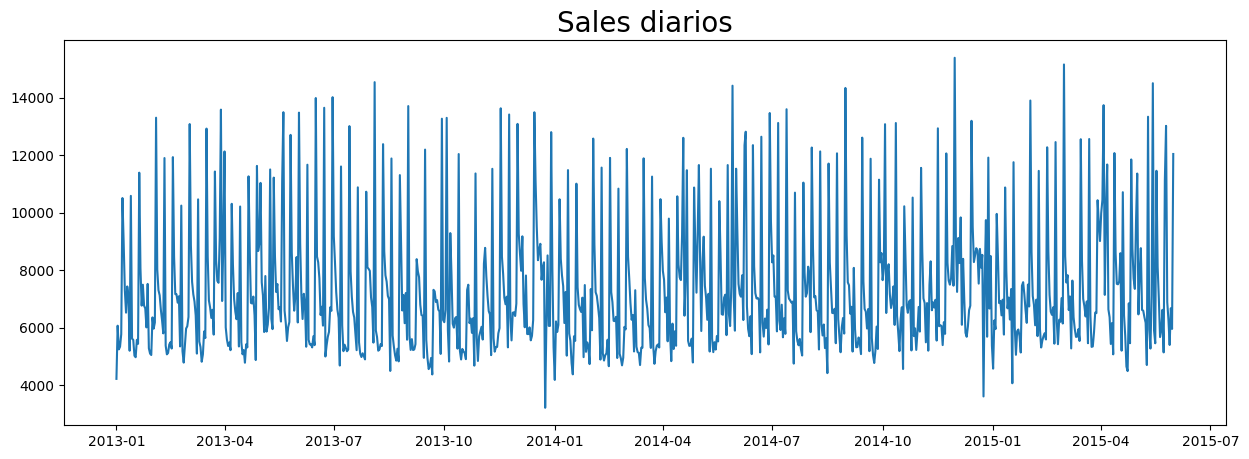

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target)
plt.title('Sales diarios',
          fontsize=20);

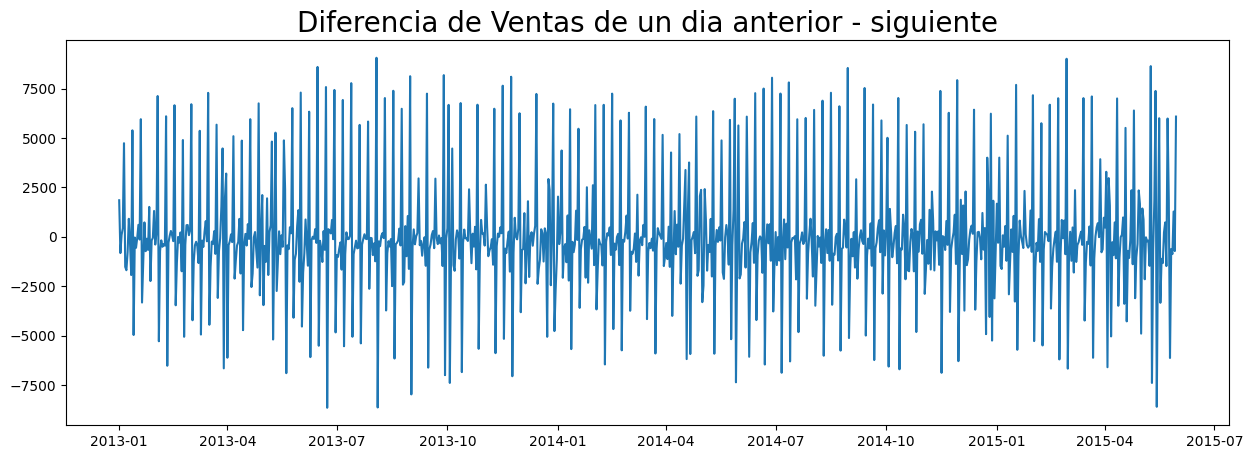

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas[:-1], np.diff(target))
plt.title('Diferencia de Ventas de un dia anterior - siguiente',
          fontsize=20);

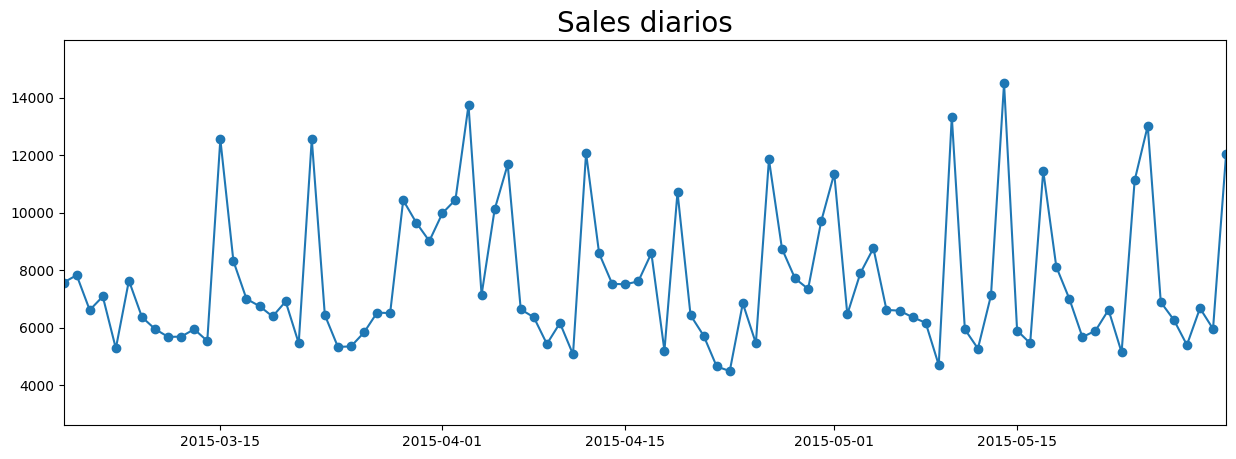

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target, 'o-')
plt.title('Sales diarios', fontsize=20)
plt.xlim([fechas[-90],fechas[-1]]);

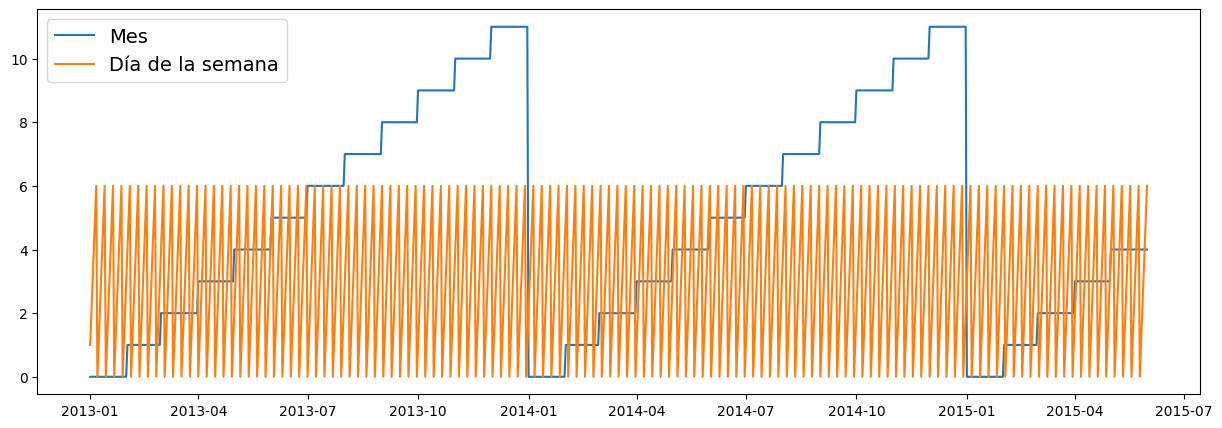

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas, month, label='Mes')
plt.plot(fechas, dow, label='Día de la semana')
plt.legend(fontsize=14);

Sales media   : 7260.399545970488


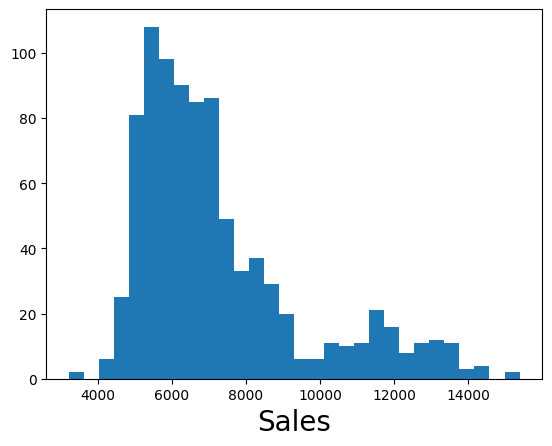

In [ ]:
plt.hist(target, bins=30)
plt.xlabel('Sales', fontsize=20)
print("Sales media   :", target.mean())

## <font color="#CA3532"> **4. Transformación de la variable a predecir**

In [ ]:
# este esclado con las funciones LOS CAMBIAREMOS  por las formulas de skinlearn con los datos de train y haremos lo propio con fit.transform
# Transformación de escala (ajustar el factor en función del problema)
# def transform(x):
#     return x/5000
# def inverse_transform(x_escalado):
#     return x_escalado*5000


# Transformación de la variable a predecir (versión identidad)
import numpy as np

def transform(x):
    # No hace nada: deja pasar el array tal cual.
    return np.asarray(x)

def inverse_transform(x):
    # Idem; no se usa para el target (usaremos y_scaler luego).
    return np.asarray(x)


## <font color="#CA3532"> **5. Enventanado de datos**

In [5]:
# vamos a coger al carpeta´s Manu las herramientas de my_utils_series_temporales.py.zip Debemos ponerlo en MyDriveFrancisco
if COLAB:
    download_file_from_google_drive(file_id='1OKWTgmKMs8XgqgynxdqVv2YKM9U94feU',
                                    dest_file='./my_utils_series_temporales.py.zip', unzip=True)
#https://drive.google.com/file/d/1OKWTgmKMs8XgqgynxdqVv2YKM9U94feU/view?usp=sharing #Dar click a compartir archivo y a cualquier persona con el enlace, copiar enlace, y hecho.

--2025-09-15 15:00:45--  https://drive.usercontent.google.com/download?id=1OKWTgmKMs8XgqgynxdqVv2YKM9U94feU&export=download&confirm=t&uuid=9699f0e2-e760-49fc-b12e-49f140095280
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.199.132, 2607:f8b0:400e:c02::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.199.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010 (2.0K) [application/octet-stream]
Saving to: ‘./my_utils_series_temporales.py.zip’

./my_utils_series_t 100%[===================>]   1.96K  --.-KB/s    in 0s      

2025-09-15 15:00:46 (41.8 MB/s) - ‘./my_utils_series_temporales.py.zip’ saved [2010/2010]



In [6]:
from my_utils_series_temporales import int2dummy, enventanar, info_enventanado, NAN

In [ ]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Store,881.0,85.0,85.0,85.0,85.0,85.0,85.0,0.0
DayOfWeek,881.0,4.003405,1.0,2.0,4.0,6.0,7.0,1.999713
Date,881,2014-03-17 00:00:00.000000256,2013-01-01 00:00:00,2013-08-09 00:00:00,2014-03-17 00:00:00,2014-10-23 00:00:00,2015-05-31 00:00:00,NaN
Sales,881.0,7260.399546,3215.0,5641.0,6613.0,8065.0,15386.0,2275.912174
Customers,881.0,1016.666288,433.0,836.0,930.0,1064.0,1992.0,288.143667
Open,881.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Promo,881.0,0.38025,0.0,0.0,0.0,1.0,1.0,0.485724
SchoolHoliday,881.0,0.182747,0.0,0.0,0.0,0.0,1.0,0.386678
StateHoliday_0,881.0,0.972758,0.0,1.0,1.0,1.0,1.0,0.16288
StateHoliday_a,881.0,0.015891,0.0,0.0,0.0,0.0,1.0,0.125125


In [ ]:
# en int2dummy el máximo marcado como entrada es un valor legal
# posiblemente cambiemos semana por prox_fin_mes pero será continua, usaremos dow 0..6 month 0..11 o mes ojo como nombramos en los arrays
# One-hot encoding únicamente para Month (0..11)
# Nota: int2dummy incluye el valor máximo, por eso ponemos 0, 11
one_hot_month = int2dummy(month, 0, 11)
one_hot_day_of_week = int2dummy(dow, 0, 6)

print(month.shape)          # (n,)
print(one_hot_month.shape)  # (n, 12)
print(one_hot_month[:5])    # vistazo a las primeras filas
print(dow.shape)            # (n,)
print(one_hot_day_of_week.shape)  # (n, 7)
one_hot_day_of_week[:5]     # vistazo a las primeras filas

(881,)
(881, 12)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(881,)
(881, 7)


array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]])

In [ ]:
month.shape

(881,)

In [ ]:
#desplegamos como se ha codificado mes hasta 12 columnas con 790 instancias
one_hot_month

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#vemos la shape para las 3 variables codificadas, semana es altura de mes en el que está, en nuesto caso 2 variables mes 0..11 dow 0..6
print(one_hot_month.shape, one_hot_day_of_week.shape)

(881, 12) (881, 7)


In [ ]:
# 1) Target sin escalar aquí
target_transf = transform(target)

# 2) Construcción de 'series' con los arrays disponibles
series = [
    target_transf,  # 0 - TARGET
    is_open,        # 1
    is_promo,       # 1
    sch_hdy,        # 3
    st_hdy_0,       # 4
    st_hdy_a,       # 5
    st_hdy_b,       # 6
    st_hdy_c,       # 7***
]

nombres_series = [
    "target_transf",
    "is_open", "is_promo", "schoolholiday",
    "StateHoliday_0", "StateHoliday_a", "StateHoliday_b", "StateHoliday_c",
]

# 3) Se_saben_antes: False solo para target
se_saben_antes = [
    False,   # target
    True, True, True,            # open/promo/schoolholiday
    True, True, True, True,      # stateholidays
]

# 4) Convertir todo a float32 (Keras feliz)
series = [np.asarray(s, dtype=np.float32) for s in series]

print(len(series), len(nombres_series), len(se_saben_antes))

8 8 8


In [ ]:
# agregamos las columnas que hemos creado con ohe OJO NO CORRER DOS veces porque agregamos más columnas de las necesarias
for i in range(one_hot_month.shape[1]):
    series.append(one_hot_month[:, i])
    nombres_series.append(f"month_{i}")
    se_saben_antes.append(True)

for i in range(one_hot_day_of_week.shape[1]):
    series.append(one_hot_day_of_week[:,i])
    nombres_series.append("day"+str(i+1))
    se_saben_antes.append(True)

print(len(series), len(nombres_series), len(se_saben_antes))

27 27 27


In [ ]:
# target_transf = transform(target)

# series = [target_transf, festivo]
# se_saben_antes = [False, True]   #decimos si se sabe antes o no para crear ventana con +1 lag adelantando el dato
# nombres_series = ["target_transf", "festivo"]  #importante aquí vamos creando la lista con los nombres que tendremos en las variables (features) vamos a ponerlo en mayusculas

# # Variables calendario sobre las que hemos hecho one-hot encoding
# for i in range(one_hot_mes.shape[1]):
#     series.append(one_hot_mes[:,i])
#     nombres_series.append("mes"+str(i+1))
#     se_saben_antes.append(True)

# for i in range(one_hot_semana.shape[1]):
#     series.append(one_hot_semana[:,i])
#     nombres_series.append("semana"+str(i+1))
#     se_saben_antes.append(True)

# for i in range(one_hot_day_of_week.shape[1]):
#     series.append(one_hot_day_of_week[:,i])
#     nombres_series.append("day"+str(i+1))
#     se_saben_antes.append(True)

In [ ]:
#comprobamos que tenemos más columnas (variables) y que seguimos con el mismo número de instancias
print(np.shape(series))
print(np.shape(se_saben_antes))

(27, 881)
(27,)


In [ ]:
lookback = 28 # lookback es otro sinónimo de W_in

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback)

print(X.shape, np.shape(y))

(881, 28, 27) (881,)


In [ ]:
info_enventanado(X[:10],y[:10],
                 nombres_series=nombres_series,
                 nombre_target="target",
                 tiempos=fechas)

10 ventanas creadas

X.shape=(10, 28, 27)  Y.shape=(10,) 

 Ventana 0: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,?27
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
is_open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000
is_promo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000
schoolholiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000
StateHoliday_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000
StateHoliday_a,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000
StateHoliday_b,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000
StateHoliday_c,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000
month_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000
month_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000


 Ventana 1: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,?26,2013-01-01T00:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4220.000000
is_open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000
is_promo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000
schoolholiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000
StateHoliday_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,1.000000
StateHoliday_a,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.000000
StateHoliday_b,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000
StateHoliday_c,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000
month_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000
month_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000


 Ventana 2: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,?25,2013-01-01T00:00:00.000000000,2013-01-02T00:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4220.000000,6069.000000
is_open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000
is_promo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000
schoolholiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000
StateHoliday_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,1.000000,1.000000
StateHoliday_a,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.000000,0.000000
StateHoliday_b,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000
StateHoliday_c,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000
month_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000
month_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000


 Ventana 3: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,?24,2013-01-01T00:00:00.000000000,2013-01-02T00:00:00.000000000,2013-01-03T00:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4220.000000,6069.000000,5246.000000
is_open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000
is_promo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000
schoolholiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000
StateHoliday_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,1.000000,1.000000,1.000000
StateHoliday_a,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.000000,0.000000,0.000000
StateHoliday_b,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000
StateHoliday_c,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000
month_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000
month_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000


 Ventana 4: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,?23,2013-01-01T00:00:00.000000000,2013-01-02T00:00:00.000000000,2013-01-03T00:00:00.000000000,2013-01-04T00:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4220.000000,6069.000000,5246.000000,5339.000000
is_open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000
is_promo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000
schoolholiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,0.000000
StateHoliday_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,1.000000,1.000000,1.000000,1.000000
StateHoliday_a,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_b,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_c,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000
month_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000
month_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000


 Ventana 5: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,?22,2013-01-01T00:00:00.000000000,2013-01-02T00:00:00.000000000,2013-01-03T00:00:00.000000000,2013-01-04T00:00:00.000000000,2013-01-05T00:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4220.000000,6069.000000,5246.000000,5339.000000,5774.000000
is_open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
is_promo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
schoolholiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
StateHoliday_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
StateHoliday_a,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_b,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_c,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
month_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
month_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


 Ventana 6: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,?21,2013-01-01T00:00:00.000000000,2013-01-02T00:00:00.000000000,2013-01-03T00:00:00.000000000,2013-01-04T00:00:00.000000000,2013-01-05T00:00:00.000000000,2013-01-06T00:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4220.000000,6069.000000,5246.000000,5339.000000,5774.000000,10509.000000
is_open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
is_promo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
schoolholiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
StateHoliday_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
StateHoliday_a,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_b,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_c,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
month_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
month_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


 Ventana 7: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,?20,2013-01-01T00:00:00.000000000,2013-01-02T00:00:00.000000000,2013-01-03T00:00:00.000000000,2013-01-04T00:00:00.000000000,2013-01-05T00:00:00.000000000,2013-01-06T00:00:00.000000000,2013-01-07T00:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4220.000000,6069.000000,5246.000000,5339.000000,5774.000000,10509.000000,8990.000000
is_open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
is_promo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
schoolholiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
StateHoliday_a,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_b,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_c,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
month_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
month_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


 Ventana 8: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,?19,2013-01-01T00:00:00.000000000,2013-01-02T00:00:00.000000000,2013-01-03T00:00:00.000000000,2013-01-04T00:00:00.000000000,2013-01-05T00:00:00.000000000,2013-01-06T00:00:00.000000000,2013-01-07T00:00:00.000000000,2013-01-08T00:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4220.000000,6069.000000,5246.000000,5339.000000,5774.000000,10509.000000,8990.000000,7300.000000
is_open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
is_promo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
schoolholiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
StateHoliday_a,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_b,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_c,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
month_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
month_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


 Ventana 9: 


,?0,?1,?2,?3,?4,?5,?6,?7,?8,?9,?10,?11,?12,?13,?14,?15,?16,?17,?18,2013-01-01T00:00:00.000000000,2013-01-02T00:00:00.000000000,2013-01-03T00:00:00.000000000,2013-01-04T00:00:00.000000000,2013-01-05T00:00:00.000000000,2013-01-06T00:00:00.000000000,2013-01-07T00:00:00.000000000,2013-01-08T00:00:00.000000000,2013-01-09T00:00:00.000000000
target_transf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4220.000000,6069.000000,5246.000000,5339.000000,5774.000000,10509.000000,8990.000000,7300.000000,6523.000000
is_open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
is_promo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
schoolholiday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
StateHoliday_a,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_b,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
StateHoliday_c,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
month_0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
month_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
print(X.shape)
print(np.shape(target))

(881, 28, 27)
(881,)


## <font color="#CA3532"> **6. Separación training-test** y además aplicaremos el MinMax escaler a los datos de Sales

In [ ]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)

In [ ]:
X_train      = X[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
y_train      = y[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
target_train = target[lookback:punto_corte] # elimino los lookback primeros al tener NANs
fechas_train = fechas[lookback:punto_corte] # elimino los lookback primeros al tener NANs

X_test       = X[punto_corte:]
y_test       = y[punto_corte:]
target_test  = target[punto_corte:]
fechas_test  = fechas[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(676,)
(177,)


In [ ]:
690+177+14

881

In [ ]:
print(X_train.shape, y_train.shape)

(676, 28, 27) (676,)


In [ ]:
# aquí aplicaremos a la columna de Sales un MinMax es un escalador en condiciones para -1..1

In [ ]:
# === Escalado correcto del TARGET (fit SOLO con TRAIN) ===
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np

#y_scaler = MinMaxScaler()
y_scaler = StandardScaler()

# 1) Ajustar con y_train (en bruto)
y_scaler.fit(y_train.reshape(-1, 1))

# 2) Transformar y (train/test)
y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test  = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

# 3) Coherencia: escalar también el CANAL 0 de X (histórico del target)
#    (para que lo que ve la red en X y lo que predice en y estén en la MISMA escala)
X_train = X_train.copy()
X_test  = X_test.copy()

X_train[:,:,0] = y_scaler.transform(X_train[:,:,0].reshape(-1, 1)) \
                           .reshape(X_train.shape[0], X_train.shape[1])
X_test[:,:,0]  = y_scaler.transform(X_test[:,:,0].reshape(-1, 1)) \
                           .reshape(X_test.shape[0],  X_test.shape[1])

# 4) Utilidad para desescalar predicciones más adelante
def inverse_transform_y(x):
    return y_scaler.inverse_transform(np.asarray(x).reshape(-1,1)).ravel()

# 5) (Recomendado) Asegurar dtypes para Keras
X_train = X_train.astype('float32');  y_train = y_train.astype('float32')
X_test  = X_test.astype('float32');   y_test  = y_test.astype('float32')


Revisamos las variables que entrarán al modelo y la escala en la que estarán (para verificar rangos de -1..1

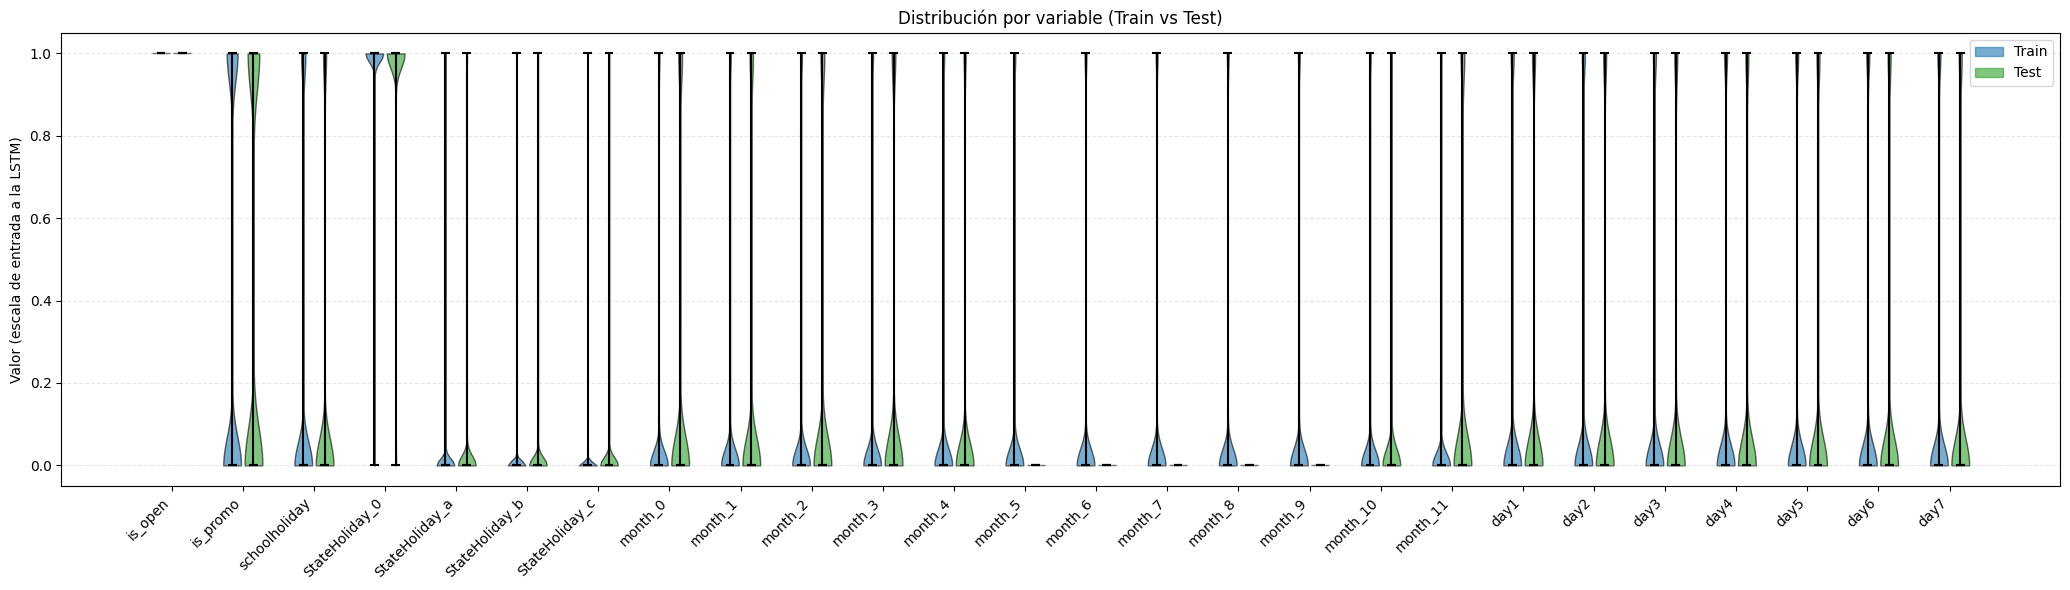

In [ ]:
# Violin plots of each feature (excluding target channel 0) with Train (blue) vs Test (green).
# Assumes variables available in the notebook: X_train, X_test, nombres_series

import numpy as np
import matplotlib.pyplot as plt

# Safety checks & setup
assert 'X_train' in globals() and 'X_test' in globals(), "X_train / X_test no encontrados."
assert 'nombres_series' in globals(), "nombres_series no encontrado."

# X shapes: (N, lookback, n_vars)
n_vars = X_train.shape[2]
feature_names = nombres_series  # length should be n_vars

# Build flattened distributions per feature excluding target (channel 0)
train_dists = []
test_dists  = []
labels      = []

for j in range(1, n_vars):  # exclude target at index 0
    # Flatten across (samples, timesteps)
    tr = X_train[:, :, j].reshape(-1)
    te = X_test[:,  :, j].reshape(-1)
    # Drop NaNs/Infs just in case
    tr = tr[np.isfinite(tr)]
    te = te[np.isfinite(te)]
    train_dists.append(tr)
    test_dists.append(te)
    labels.append(feature_names[j] if j < len(feature_names) else f"var_{j}")

# Positions for side-by-side violins
x = np.arange(len(labels))
offset = 0.15

fig = plt.figure(figsize=(max(10, len(labels)*0.8), 6))
ax = fig.add_subplot(1,1,1)

parts_tr = ax.violinplot(train_dists, positions=x - offset, widths=0.25, showmeans=False, showextrema=True, showmedians=True)
parts_te = ax.violinplot(test_dists,  positions=x + offset, widths=0.25, showmeans=False, showextrema=True, showmedians=True)

# Color styling per user request: Train blue, Test green
for pc in parts_tr['bodies']:
    pc.set_facecolor('tab:blue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.6)
parts_tr['cmedians'].set_color('black')
parts_tr['cbars'].set_color('black')
parts_tr['cmins'].set_color('black')
parts_tr['cmaxes'].set_color('black')

for pc in parts_te['bodies']:
    pc.set_facecolor('tab:green')
    pc.set_edgecolor('black')
    pc.set_alpha(0.6)
parts_te['cmedians'].set_color('black')
parts_te['cbars'].set_color('black')
parts_te['cmins'].set_color('black')
parts_te['cmaxes'].set_color('black')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title('Distribución por variable (Train vs Test)')
ax.set_ylabel('Valor (escala de entrada a la LSTM)')
ax.grid(True, axis='y', linestyle='--', alpha=0.3)

# Manual legend
import matplotlib.patches as mpatches
blue_patch  = mpatches.Patch(color='tab:blue', alpha=0.6, label='Train')
green_patch = mpatches.Patch(color='tab:green', alpha=0.6, label='Test')
ax.legend(handles=[blue_patch, green_patch])

plt.tight_layout()
plt.show()

Verificamos la escala en la que tenemos y_train test

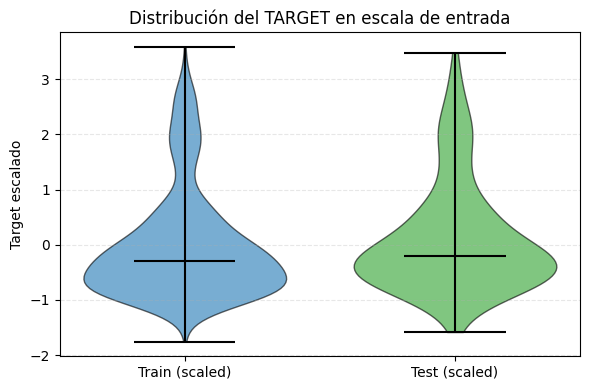

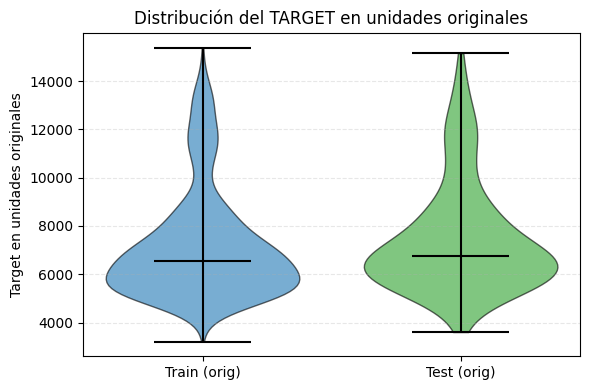

In [ ]:
# Violin plots for TARGET series: Train vs Test
# Assumes variables available: y_train, y_test (scaled), target_train, target_test (original), and y_scaler for inverse_transform

import numpy as np
import matplotlib.pyplot as plt

# Determine availability
have_scaled = 'y_train' in globals() and 'y_test' in globals()
have_original = 'target_train' in globals() and 'target_test' in globals()

if not have_scaled and not have_original:
    raise RuntimeError("No se encontraron ni y_train/y_test (escalados) ni target_train/target_test (originales).")

# 1) Violin plot en ESCALA DEL MODELO (si existe)
if have_scaled:
    fig1 = plt.figure(figsize=(6,4))
    ax1 = fig1.add_subplot(1,1,1)
    positions = [0.9, 1.1]
    parts_tr = ax1.violinplot([y_train], positions=[positions[0]], widths=0.15, showmedians=True, showextrema=True)
    parts_te = ax1.violinplot([y_test],  positions=[positions[1]], widths=0.15, showmedians=True, showextrema=True)

    # Colores
    for pc in parts_tr['bodies']:
        pc.set_facecolor('tab:blue'); pc.set_edgecolor('black'); pc.set_alpha(0.6)
    parts_tr['cmedians'].set_color('black'); parts_tr['cbars'].set_color('black'); parts_tr['cmins'].set_color('black'); parts_tr['cmaxes'].set_color('black')

    for pc in parts_te['bodies']:
        pc.set_facecolor('tab:green'); pc.set_edgecolor('black'); pc.set_alpha(0.6)
    parts_te['cmedians'].set_color('black'); parts_te['cbars'].set_color('black'); parts_te['cmins'].set_color('black'); parts_te['cmaxes'].set_color('black')

    ax1.set_xticks(positions)
    ax1.set_xticklabels(['Train (scaled)', 'Test (scaled)'])
    ax1.set_ylabel('Target escalado')
    ax1.set_title('Distribución del TARGET en escala de entrada')
    ax1.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 2) Violin plot en UNIDADES ORIGINALES (si existe o si podemos invertir)
if have_original:
    tr = np.asarray(target_train).reshape(-1)
    te = np.asarray(target_test).reshape(-1)
elif have_scaled and 'y_scaler' in globals():
    # Invertimos a unidades originales usando el scaler del target
    tr = y_scaler.inverse_transform(np.asarray(y_train).reshape(-1,1)).reshape(-1)
    te = y_scaler.inverse_transform(np.asarray(y_test).reshape(-1,1)).reshape(-1)
else:
    tr = None; te = None

if tr is not None and te is not None:
    fig2 = plt.figure(figsize=(6,4))
    ax2 = fig2.add_subplot(1,1,1)
    positions = [0.9, 1.1]
    parts_tr = ax2.violinplot([tr], positions=[positions[0]], widths=0.15, showmedians=True, showextrema=True)
    parts_te = ax2.violinplot([te], positions=[positions[1]], widths=0.15, showmedians=True, showextrema=True)

    for pc in parts_tr['bodies']:
        pc.set_facecolor('tab:blue'); pc.set_edgecolor('black'); pc.set_alpha(0.6)
    parts_tr['cmedians'].set_color('black'); parts_tr['cbars'].set_color('black'); parts_tr['cmins'].set_color('black'); parts_tr['cmaxes'].set_color('black')

    for pc in parts_te['bodies']:
        pc.set_facecolor('tab:green'); pc.set_edgecolor('black'); pc.set_alpha(0.6)
    parts_te['cmedians'].set_color('black'); parts_te['cbars'].set_color('black'); parts_te['cmins'].set_color('black'); parts_te['cmaxes'].set_color('black')

    ax2.set_xticks(positions)
    ax2.set_xticklabels(['Train (orig)', 'Test (orig)'])
    ax2.set_ylabel('Target en unidades originales')
    ax2.set_title('Distribución del TARGET en unidades originales')
    ax2.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


## <font color="#CA3532"> **7. Construcción del modelo con Keras**

In [ ]:
#from keras.optimizers import Adam

In [ ]:
#hyperparametros   neurons, dropout
from keras import optimizers

neurons = 10
#DROPOUT = 0.8
#l_r           = 0.0005
#opt = optimizers.RMSprop(learning_rate=l_r)
opt = optimizers.RMSprop()
#opt = optimizers.Adam()

model = Sequential()
model.add(LSTM(neurons, input_shape=(lookback, X_train.shape[2]),
               # kernel_regularizer='l1'
               #dropout=DROPOUT,
              )
         )
model.add(Dense(1, # kernel_regularizer='l1'
               )
         )
model.compile(
              loss='mean_squared_error',
              #loss="mean_absolute_error",
              #optimizer='adam',
              optimizer=opt,
              #optimizer=Adam(learning_rate=0.01), # más rápido
              metrics=['mse']) # 'RMSprop'
# mean_absolute_error

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.optimizer.learning_rate

<Variable path=rmsprop/learning_rate, shape=(), dtype=float32, value=0.0010000000474974513>

In [ ]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 10)             │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,531 (5.98 KB)

 Trainable params: 1,531 (5.98 KB)

 Non-trainable params: 0 (0.00 B)

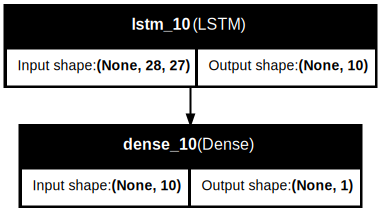

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot

if COLAB:
  display(SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog="dot",
                                                                   format="svg")))
else:
  display(SVG(model_to_dot(model, show_shapes=True).create(prog="dot",
                                                           format="svg")))

In [ ]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()


Epoch 1: val_mse improved from inf to 1.10719, saving model to model_current_best.h5



Epoch 1: val_mse improved from 1.10719 to 1.03157, saving model to model_current_best.h5



Epoch 1: val_mse improved from 1.03157 to 1.00471, saving model to model_current_best.h5



Epoch 1: val_mse improved from 1.00471 to 0.99546, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.99546 to 0.99396, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.99396 to 0.98396, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.98396 to 0.97823, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.97823 to 0.95993, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.95993 to 0.95549, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.95549 to 0.93677, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.93677 to 0.92591, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.92591 to 0.91062, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.91062 to 0.87885, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.87885 to 0.86391, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.86391 to 0.84836, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.84836 to 0.83208, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.83208 to 0.81508, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.81508 to 0.78457, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.78457 to 0.76413, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.76413 to 0.75135, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.75135 to 0.72121, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.72121

Epoch 1: val_mse improved from 0.72121 to 0.69138, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.69138 to 0.67320, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.67320

Epoch 1: val_mse improved from 0.67320 to 0.65476, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.65476 to 0.62144, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.62144

Epoch 1: val_mse improved from 0.62144 to 0.60543, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.60543 to 0.58993, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.58993 to 0.58759, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.58759 to 0.57402, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.57402

Epoch 1: val_mse did not improve from 0.57402

Epoch 1: val_mse improved from 0.57402 to 0.52276, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.52276

Epoch 1: val_mse improved from 0.52276 to 0.50036, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.50036

Epoch 1: val_mse improved from 0.50036 to 0.49463, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.49463 to 0.46356, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.46356 to 0.45948, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.45948

Epoch 1: val_mse did not improve from 0.45948

Epoch 1: val_mse improved from 0.45948 to 0.42657, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.42657

Epoch 1: val_mse did not improve from 0.42657

Epoch 1: val_mse improved from 0.42657 to 0.41748, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.41748 to 0.39543, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.39543

Epoch 1: val_mse did not improve from 0.39543


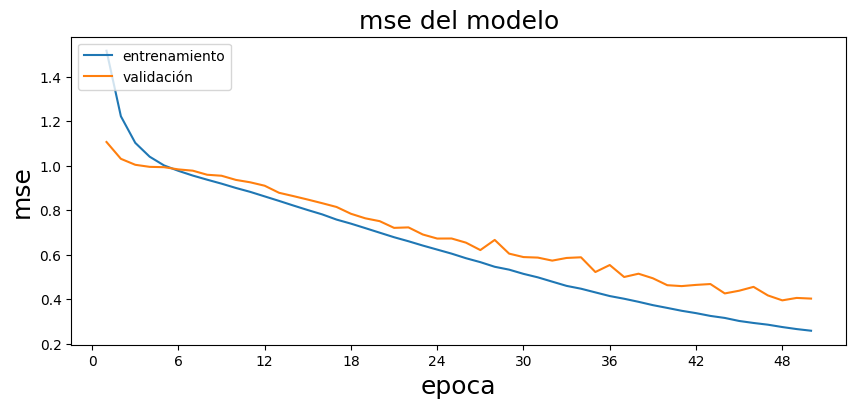


Epoch 1: val_mse improved from 0.39543 to 0.38409, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.38409 to 0.37492, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.37492 to 0.34228, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.34228

Epoch 1: val_mse did not improve from 0.34228

Epoch 1: val_mse improved from 0.34228 to 0.34043, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.34043 to 0.33626, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.33626 to 0.30795, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.30795

Epoch 1: val_mse improved from 0.30795 to 0.30141, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.30141

Epoch 1: val_mse did not improve from 0.30141

Epoch 1: val_mse improved from 0.30141 to 0.29889, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.29889

Epoch 1: val_mse improved from 0.29889 to 0.28455, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.28455 to 0.27807, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.27807

Epoch 1: val_mse did not improve from 0.27807

Epoch 1: val_mse did not improve from 0.27807

Epoch 1: val_mse did not improve from 0.27807

Epoch 1: val_mse improved from 0.27807 to 0.27224, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.27224 to 0.26873, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.26873

Epoch 1: val_mse improved from 0.26873 to 0.26449, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.26449

Epoch 1: val_mse improved from 0.26449 to 0.26391, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.26391

Epoch 1: val_mse did not improve from 0.26391

Epoch 1: val_mse did not improve from 0.26391

Epoch 1: val_mse did not improve from 0.26391

Epoch 1: val_mse did not improve from 0.26391

Epoch 1: val_mse improved from 0.26391 to 0.26352, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.26352 to 0.25775, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.25775 to 0.25051, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.25051

Epoch 1: val_mse did not improve from 0.25051

Epoch 1: val_mse did not improve from 0.25051

Epoch 1: val_mse improved from 0.25051 to 0.24569, saving model to model_current_best.h5



Epoch 1: val_mse improved from 0.24569 to 0.24373, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.24373

Epoch 1: val_mse did not improve from 0.24373

Epoch 1: val_mse did not improve from 0.24373

Epoch 1: val_mse did not improve from 0.24373

Epoch 1: val_mse did not improve from 0.24373

Epoch 1: val_mse did not improve from 0.24373

Epoch 1: val_mse did not improve from 0.24373

Epoch 1: val_mse did not improve from 0.24373

Epoch 1: val_mse did not improve from 0.24373

Epoch 1: val_mse improved from 0.24373 to 0.23661, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.23661


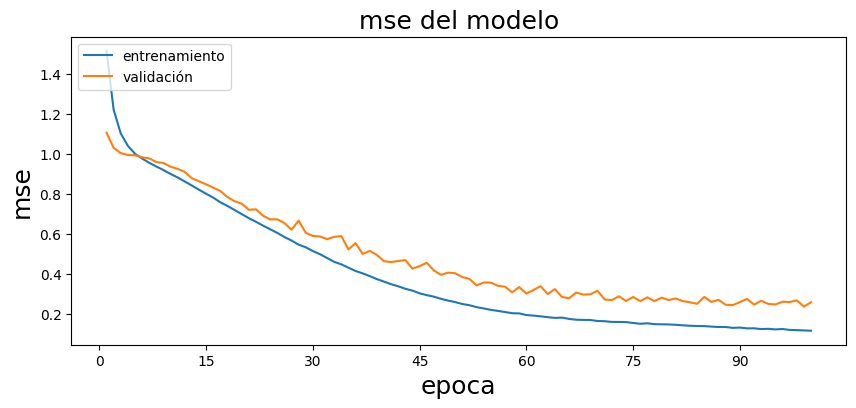


Epoch 1: val_mse did not improve from 0.23661

Epoch 1: val_mse improved from 0.23661 to 0.23570, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.23570

Epoch 1: val_mse did not improve from 0.23570

Epoch 1: val_mse did not improve from 0.23570

Epoch 1: val_mse did not improve from 0.23570

Epoch 1: val_mse did not improve from 0.23570

Epoch 1: val_mse did not improve from 0.23570

Epoch 1: val_mse improved from 0.23570 to 0.22971, saving model to model_current_best.h5



Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val_mse did not improve from 0.22971

Epoch 1: val


Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662


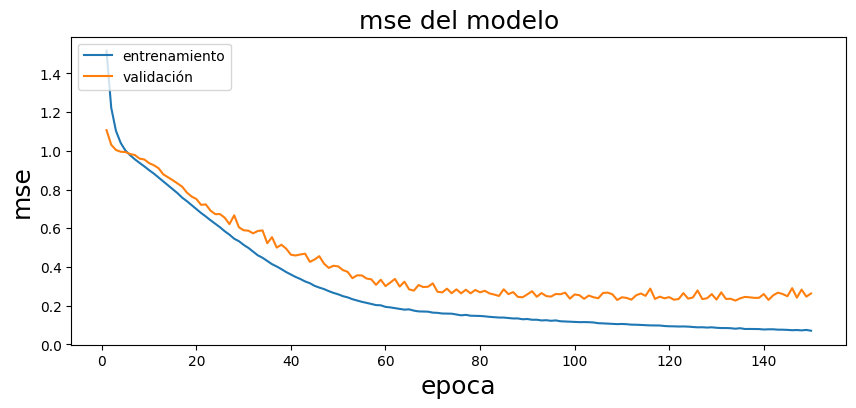


Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val

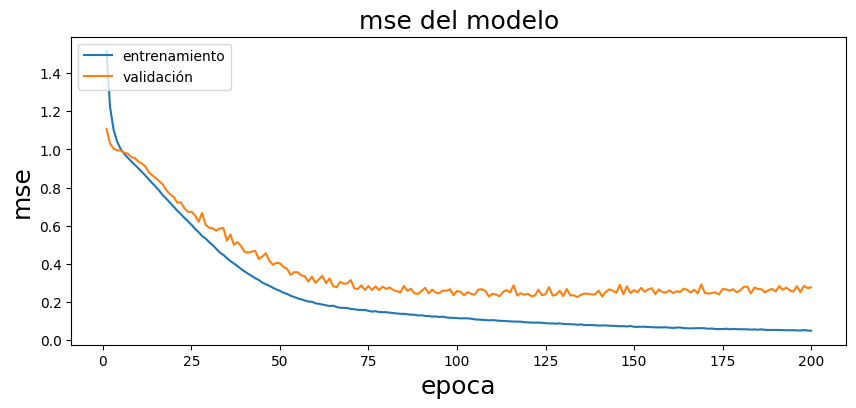


Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val

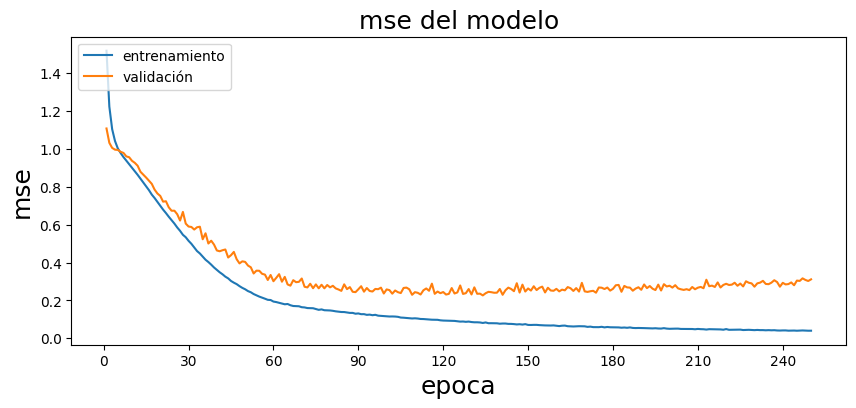


Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val_mse did not improve from 0.22662

Epoch 1: val

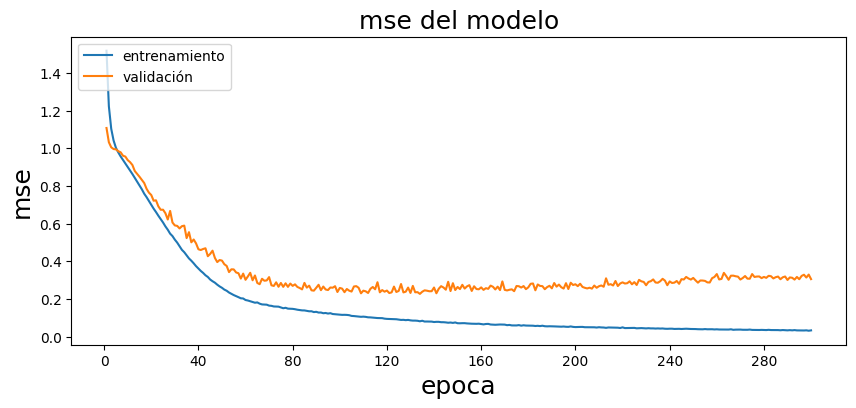

In [ ]:
epochs = 300
batch_size = 64
Nval = 200
control_sobreajuste_val = True

if not control_sobreajuste_val:
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=2)
else:
    acum_tr_mse = []
    acum_val_mse = []
    modelpath="model_current_best.h5"
    checkpoint = ModelCheckpoint(modelpath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    callbacks_list = [checkpoint]

    for e in range(epochs):
        aux = X_train[:-Nval]
        history = model.fit(aux, y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))

        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error

        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)

In [ ]:
model = load_model(modelpath) # recupero el mejor modelo en validación

## <font color="#CA3532"> **8. Chequeo del modelo (predicción a un día)**

In [ ]:
y_train_prediction = model.predict(X_train).flatten()
y_test_prediction = model.predict(X_test).flatten()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
# aquí cambiamos el desescalamiento
# target_train_pred = inverse_transform(y_train_prediction)
# target_test_pred  = inverse_transform(y_test_prediction)
target_train_pred = inverse_transform_y(y_train_prediction)
target_test_pred  = inverse_transform_y(y_test_prediction)

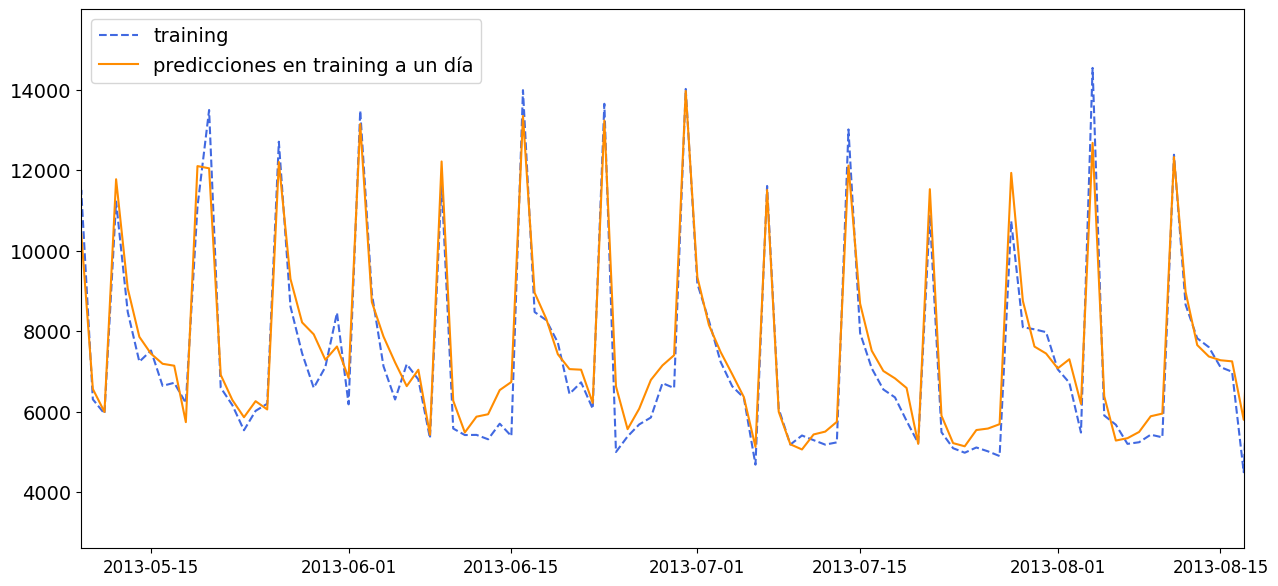

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label="training")
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label="predicciones en training a un día")

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlim([fechas_train[100],fechas_train[200]])
plt.legend(fontsize=14);

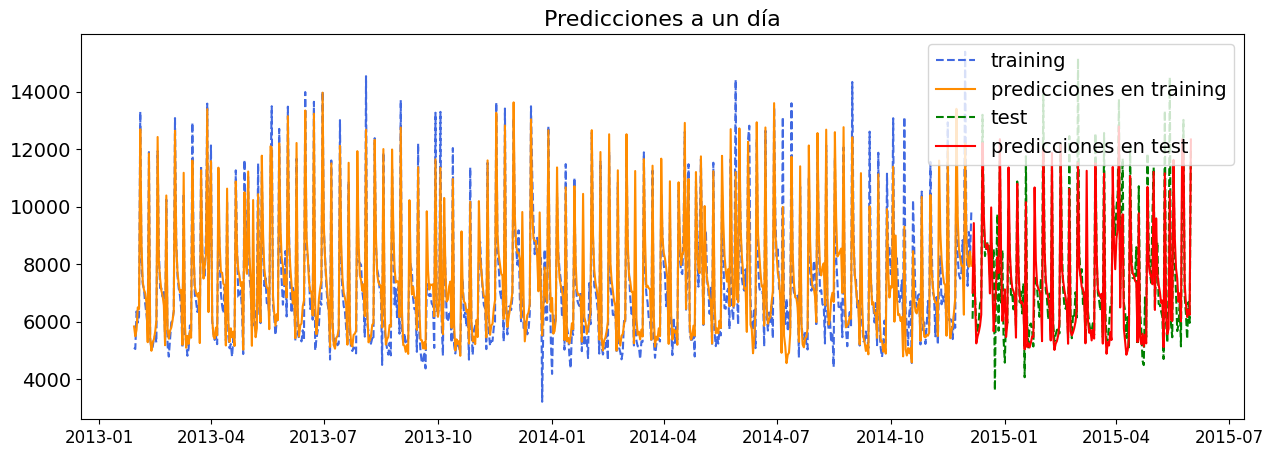

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.title('Predicciones a un día', fontsize=16)
plt.legend(fontsize=14);

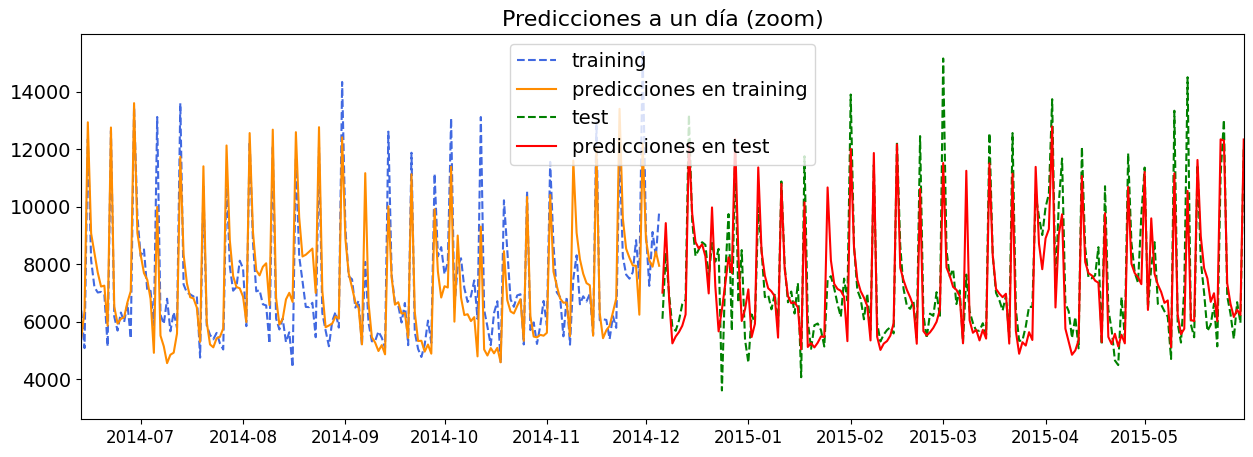

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.title('Predicciones a un día (zoom)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlim([fechas_train[500],fechas_test[-1]]);

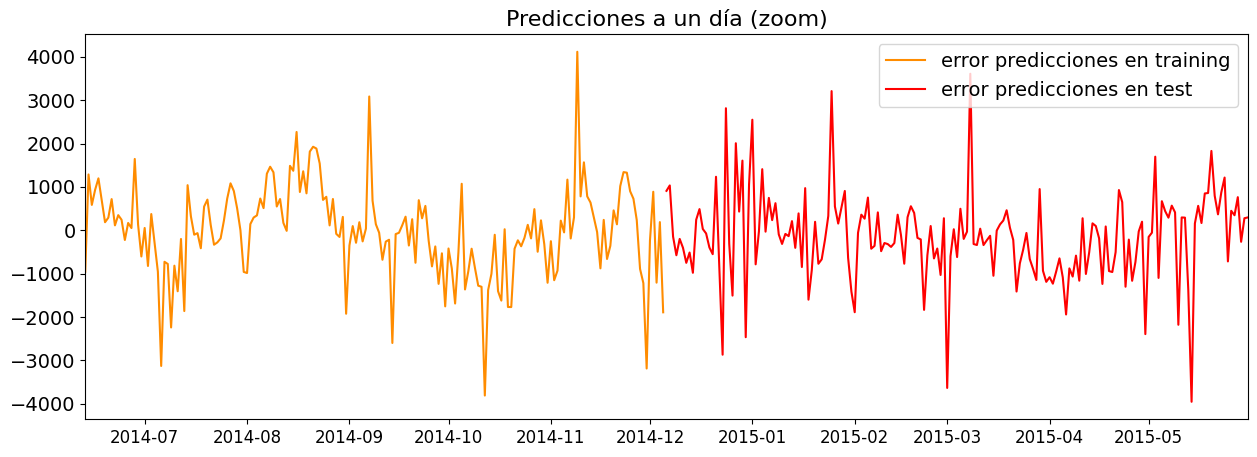

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train_pred - target_train,  c='darkorange',
         label='error predicciones en training')
plt.plot(fechas_test, target_test_pred - target_test,    c='red',
         label='error predicciones en test')
plt.title('Predicciones a un día (zoom)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlim([fechas_train[500],fechas_test[-1]]);

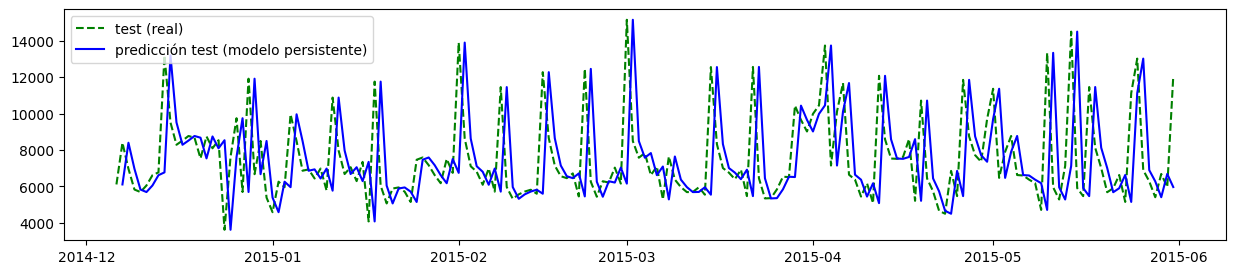

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test (real)')
plt.plot(fechas_test[1:], target_test[:-1], '-',   c='blue',
         label='predicción test (modelo persistente)')
plt.legend();

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

# =======================
# 1) Métricas (escala original)
# =======================
rmse_train = np.sqrt(mean_squared_error(target_train[1:], target_train_pred[1:]))
rmse_test  = np.sqrt(mean_squared_error(target_test,  target_test_pred))

r2_train   = r2_score(target_train[1:], target_train_pred[1:])
r2_test    = r2_score(target_test,      target_test_pred)

# =======================
# 2) Persistencias y Skill Scores (h = 1, 5, 28)
# =======================
def mse_persist(target, h):
    return mean_squared_error(target[h:], target[:-h])

mse_model = mean_squared_error(target_test, target_test_pred)

mse_p1  = mse_persist(target_test, 1)
mse_p5  = mse_persist(target_test, 5)
mse_p28 = mse_persist(target_test, 28)

skill_1  = 1 - (mse_model / mse_p1)
skill_5  = 1 - (mse_model / mse_p5)
skill_28 = 1 - (mse_model / mse_p28)

# (Opcional) R2 de las persistencias para referencia
r2_p1  = r2_score(target_test[1:],  target_test[:-1])
r2_p5  = r2_score(target_test[5:],  target_test[:-5])
r2_p28 = r2_score(target_test[28:], target_test[:-28])

# =======================
# 3) Hiperparámetros (solo los 4 que queremos registrar)
# =======================
try:   neurons  = model.layers[0].units
except: neurons = None
dropout    = getattr(model.layers[0], "dropout", 0.0)
lookback   = lookback          # ya definido en tu notebook
batch_size = batch_size        # ya definido en tu notebook

# =======================
# 4) Registro para el DataFrame
# =======================
res = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "lookback": lookback,
    "neurons": neurons,
    "dropout": dropout,
    "batch_size": batch_size,
    "optimizer": opt.__class__.__name__,
    "R2_train": r2_train,
    "R2_test": r2_test,
    "RMSE_train": rmse_train,
    "RMSE_test": rmse_test,
    "Skill_1d": skill_1,
    "Skill_5d": skill_5,
    "Skill_28d": skill_28,
    "R2_persist_1d": r2_p1,
    "R2_persist_5d": r2_p5,
    "R2_persist_28d": r2_p28,
}

try:
    resultados = pd.concat([resultados, pd.DataFrame([res])], ignore_index=True)
except NameError:
    resultados = pd.DataFrame([res])

display(resultados.tail(10))


,timestamp,lookback,neurons,dropout,batch_size,optimizer,R2_train,R2_test,RMSE_train,RMSE_test,Skill_1d,Skill_5d,Skill_28d,R2_persist_1d,R2_persist_5d,R2_persist_28d,learning_rate
0,2025-09-15 10:37:07,7,5,0.0,64,Adam,0.857285,0.755832,856.390433,1135.170727,0.870960,0.891555,0.645425,-0.885526,-1.210105,0.338233,NaN
1,2025-09-15 10:42:28,7,10,0.0,64,Adam,0.888947,0.770428,755.445515,1100.718934,0.878674,0.898037,0.666621,-0.885526,-1.210105,0.338233,NaN
2,2025-09-15 10:44:11,14,10,0.0,64,Adam,0.873011,0.786390,809.522254,1061.763290,0.887110,0.905127,0.689801,-0.885526,-1.210105,0.338233,NaN
3,2025-09-15 10:46:19,14,5,0.0,64,Adam,0.885146,0.789831,769.870897,1053.176575,0.888928,0.906655,0.694798,-0.885526,-1.210105,0.338233,NaN
4,2025-09-15 10:59:59,14,5,0.0,64,RMSprop,0.889202,0.780373,756.157054,1076.612963,0.883930,0.902454,0.681063,-0.885526,-1.210105,0.338233,NaN
5,2025-09-15 11:01:46,14,10,0.0,64,RMSprop,0.887844,0.795522,760.776313,1038.820437,0.891936,0.909182,0.703062,-0.885526,-1.210105,0.338233,NaN
6,2025-09-15 11:04:31,14,10,0.0,64,RMSprop,0.847777,0.697528,886.309060,1263.455502,0.840147,0.865659,0.560756,-0.885526,-1.210105,0.338233,NaN
7,2025-09-15 11:09:47,7,10,0.0,64,RMSprop,0.857672,0.769758,855.229224,1102.324195,0.878320,0.897740,0.665648,-0.885526,-1.210105,0.338233,"<Variable path=rmsprop/learning_rate, shape=()..."
8,2025-09-15 11:11:52,28,10,0.0,64,RMSprop,0.870893,0.799370,819.513284,1028.999596,0.893969,0.910891,0.708649,-0.885526,-1.210105,0.338233,"<Variable path=rmsprop/learning_rate, shape=()..."
9,2025-09-15 11:16:02,28,10,0.0,64,RMSprop,0.866729,0.800322,832.622440,1026.554610,0.894473,0.911314,0.710032,-0.885526,-1.210105,0.338233,NaN


In [ ]:
#import pandas as pd

#resultados = pd.read_csv("./data/resultados_lstm.csv")

In [ ]:
# Modelos de referencia: modelo persistente (a 1 día, 7 días etc.)
# Lo que intentamos capturar aquí son cosas como "hoy es domingo, vamos a ver qué tal predice lo de mañana Lunes.. luego al próximo domingo.. luego al próximo domingo del siguiente mes... y luego al mismo domingo pero del año que viene, si está capturando algo de todo el año.. de un domingo a un lunes las cosas pueden cambiar mucho!"
# R2 scores
print("R2 del modelo en training      : ",
      R2_score(target_train[1:], target_train_pred[1:]))
print("R2 del modelo en test          : ",
      R2_score(target_test, target_test_pred))
print("R2 modelo persistente 1 día    : ",
      R2_score(target_test[1:], target_test[:-1]))
print("R2 modelo persistente 1 semana : ",
      R2_score(target_test[7:], target_test[:-7]))
print("R2 modelo persistente 4 semanas: ",
      R2_score(target_test[28:], target_test[:-28]))
print("R2 modelo persistente 1 año: ",
      R2_score(target_train[7*52:], target_train[:-7*52]))

R2 del modelo en training      :  0.8667289913769876
R2 del modelo en test          :  0.8003222149821246
R2 modelo persistente 1 día    :  -0.8855262718909758
R2 modelo persistente 1 semana :  -0.15406645715220146
R2 modelo persistente 4 semanas:  0.3382327488119595
R2 modelo persistente 1 año:  0.4027406426928545


In [ ]:
# R2(y_real, y_predicho) = 1 - MSE/VAR(y real)
# r2(v1, v2) # correlación lineal

# r2(precio en euros, precio en céntimos de euros) = 1.
# ** R2(precio en euros, precio en céntimos de euros) = 1 - promedio((precio1-precio2)^2)/VAR(precio1) << -1

In [ ]:
# RMSEs
sqrt = np.sqrt
print("RMSE del modelo en training      : ",
      sqrt(mean_squared_error(target_train[1:],
                              target_train_pred[1:])))
print("RMSE del modelo en test          : ",
      sqrt(mean_squared_error(target_test,
                              target_test_pred)))
print("RMSE modelo persistente 1 día    : ",
      sqrt(mean_squared_error(target_test[1:],
                              target_test[:-1])))
print("RMSE modelo persistente 1 semana : ",
      sqrt(mean_squared_error(target_test[7:],
                              target_test[:-7])))
print("RMSE modelo persistente 4 semanas: ",
      sqrt(mean_squared_error(target_test[28:],
                              target_test[:-28])))

RMSE del modelo en training      :  832.6224402118877
RMSE del modelo en test          :  1026.5546096850117
RMSE modelo persistente 1 día    :  3160.0913779581524
RMSE modelo persistente 1 semana :  2501.3301120427436
RMSE modelo persistente 4 semanas:  1906.3703098792903


## <font color="#CA3532"> **9. Predicciones a varios días en test mediante un modelo generativo**

In [ ]:
def step_generativo(model, ventana, X, i):
    # ventana: va a tener dimensiones (1, lookback, n_variables)
    # El target está en (0,:,0)
    # La posición (0,0,0) es el target en el día más antiguo de la ventana
    # La posición (0,0,-1) es el target en el día más reciente de la ventana
    # Las variables calendario están en (0,:,1:)
    # Las variables calendario para el último día de la ventana están en (0,-1,1:)

    z = model.predict(ventana, verbose=0)[0,0] # predicción nueva
    target_pred = inverse_transform_y(z) #usamos la nueva función que MinMax a Train e inverse
    ventana_nueva = None
    if i < (len(X)-1):
        ventana_nueva = np.zeros(ventana.shape)
        # muevo un día hacia atrás todas las variables de la ventana:
        ventana_nueva[0,:-1,:] = ventana[0,1:,:].copy()

        # introduzco las variables calendario para el último día de la ventana:
        ventana_nueva[0,-1,1:] = X[i+1,-1,1:]

        # meto la predicción como última obervación del target:
        ventana_nueva[0,-1,0] = z


    return target_pred, ventana_nueva

In [ ]:
def generativo(model, X):
    ventana = np.array([X[0]]).copy()
    salidas = []
    for i in range(len(X)):
        target_pred, ventana_nueva = step_generativo(model, ventana, X, i)
        salidas.append(target_pred)
        ventana = ventana_nueva

    return salidas

In [ ]:
sal = generativo(model, X_test)

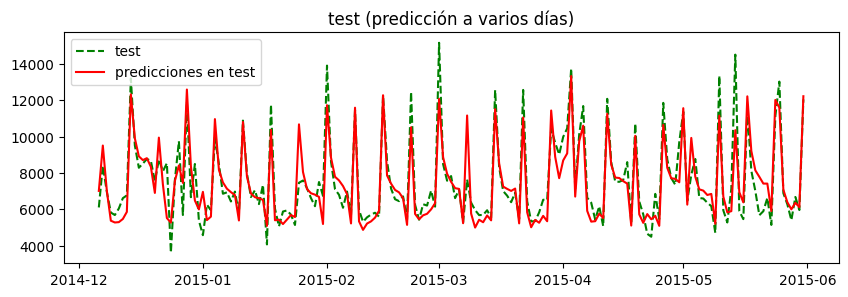

In [ ]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,1,1)
ax.plot(fechas_test, target_test, '--g', label='test')
plt.plot(fechas_test, sal, 'r', label='predicciones en test')
plt.title('test (predicción a varios días)')
plt.legend();

In [ ]:
preds = pd.DataFrame({"fecha": fechas_test,
                      "Sales estimados":sal})
preds.to_csv("predicciones.csv")
preds

,fecha,Sales estimados
0,2014-12-06,[7010.509]
1,2014-12-07,[9504.01]
2,2014-12-08,[7014.711]
3,2014-12-09,[5372.819]
4,2014-12-10,[5274.4087]
...,...,...
172,2015-05-27,[6385.5625]
173,2015-05-28,[5998.283]
174,2015-05-29,[6358.4116]
175,2015-05-30,[6116.1255]
